In [1]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs , make_circles, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import (silhouette_score, adjusted_rand_score , calinski_harabasz_score,
    davies_bouldin_score, fowlkes_mallows_score, normalized_mutual_info_score, completeness_score, homogeneity_score, v_measure_score)

from scipy.cluster.hierarchy import fcluster, linkage as scipy_linkage , dendrogram
from scipy.cluster.hierarchy import linkage as scipy_linkage
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


# **Helper Functions for Hierarchical Clustering**

In [2]:
def create_sample_datasets():
    """Create various sample datasets for hierarchical clustering demonstration"""
    np.random.seed(42)
    
    # Dataset 1: Blobs
    blob_data, blob_labels = make_blobs(n_samples=200, centers=4, n_features=2, cluster_std=1.0, random_state=42)
    
    # Dataset 2: Circles
    circle_data, circle_labels = make_circles(n_samples=200, noise=0.1, factor=0.6, random_state=42)
    
    # Dataset 3: Moons
    moon_data, moon_labels = make_moons(n_samples=200, noise=0.1, random_state=42)
    
    # Dataset 4: Anisotropic blobs
    X, y = make_blobs(n_samples=200, centers=3, random_state=42)
    transformation = [[0.6, -0.6], [-0.4, 0.8]]
    aniso_data = np.dot(X, transformation)
    aniso_labels = y
    
    return {
        'blobs': (blob_data, blob_labels),
        'circles': (circle_data, circle_labels),
        'moons': (moon_data, moon_labels),
        'anisotropic': (aniso_data, aniso_labels)
    }

def plot_dendrogram(model, X, labels=None, title="Hierarchical Clustering Dendrogram", figsize=(12, 8), max_display=30):
    """
    Plot dendrogram for hierarchical clustering
    
    Parameters:
    -----------
    model : sklearn AgglomerativeClustering or linkage matrix
        Fitted clustering model or precomputed linkage matrix
    X : array-like
        Original data (for truncation if needed)
    labels : array-like, optional
        Data point labels
    title : str
        Plot title
    figsize : tuple
        Figure size
    max_display : int
        Maximum number of leaf nodes to display
    """
    
    plt.figure(figsize=figsize)
    
    # If model is AgglomerativeClustering, we need to create linkage matrix
    if hasattr(model, 'children_'):
        # Create linkage matrix from AgglomerativeClustering
        counts = np.zeros(model.children_.shape[0])
        n_samples = len(model.labels_)
        for i, merge in enumerate(model.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count
        linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    else:
        # Assume it's already a linkage matrix
        linkage_matrix = model
    
    # Plot dendrogram
    dendrogram(linkage_matrix,  truncate_mode='lastp' if len(X) > max_display else None, p=max_display if len(X) > max_display else len(X), orientation='top', distance_sort='descending', show_leaf_counts=True)
    
    plt.title(title)
    plt.xlabel('Sample Index or (Cluster Size)')
    plt.ylabel('Distance')
    plt.grid(True, alpha=0.3)
    
    return plt.gcf()

def evaluate_clustering_quality(X, labels, true_labels=None):
    """
    Evaluate clustering quality using multiple metrics
    
    Parameters:
    -----------
    X : array-like
        Original data
    labels : array-like
        Cluster labels
    true_labels : array-like, optional
        True labels for external validation
    
    Returns:
    --------
    metrics : dict
        Dictionary containing various quality metrics
    """
    metrics = {}
    
    # Internal metrics (don't require true labels)
    if len(np.unique(labels)) > 1:
        metrics['silhouette_score'] = silhouette_score(X, labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    
    # External metrics (require true labels)
    if true_labels is not None:
        metrics['adjusted_rand_score'] = adjusted_rand_score(true_labels, labels)
        metrics['normalized_mutual_info'] = normalized_mutual_info_score(true_labels, labels)
        metrics['fowlkes_mallows'] = fowlkes_mallows_score(true_labels, labels)
        metrics['homogeneity'] = homogeneity_score(true_labels, labels)
        metrics['completeness'] = completeness_score(true_labels, labels)
        metrics['v_measure'] = v_measure_score(true_labels, labels)
    
    return metrics

def optimal_clusters_elbow(X, max_clusters=15, linkage='ward', metric='euclidean'):
    """
    Find optimal number of clusters using elbow method
    
    Parameters:
    -----------
    X : array-like
        Input data
    max_clusters : int
        Maximum number of clusters to test
    linkage : str
        Linkage criterion
    metric : str
        Distance metric
    
    Returns:
    --------
    optimal_k : int
        Optimal number of clusters
    inertias : list
        Within-cluster sum of squares for each k
    """
    
    # Compute linkage matrix
    linkage_matrix = scipy_linkage(X, method=linkage, metric=metric)
    
    inertias = []
    k_range = range(2, min(max_clusters + 1, len(X)))
    
    for k in k_range:
        # Get cluster labels
        cluster_labels = fcluster(linkage_matrix, k, criterion='maxclust')
        
        # Calculate within-cluster sum of squares
        inertia = 0
        for cluster_id in np.unique(cluster_labels):
            cluster_points = X[cluster_labels == cluster_id]
            if len(cluster_points) > 0:
                centroid = np.mean(cluster_points, axis=0)
                inertia += np.sum((cluster_points - centroid) ** 2)
        
        inertias.append(inertia)
    
    # Find elbow using the "kneedle" method (simplified)
    # Calculate the rate of change
    if len(inertias) >= 3:
        diffs = np.diff(inertias)
        diff_diffs = np.diff(diffs)
        
        # Find point where the rate of change starts to level off
        optimal_idx = np.argmax(diff_diffs) + 2  # +2 because of double diff
        optimal_k = k_range[optimal_idx] if optimal_idx < len(k_range) else k_range[-1]
    else:
        optimal_k = k_range[0]
    
    return optimal_k, list(k_range), inertias

def plot_clustering_comparison(X, methods=['ward', 'complete', 'average', 'single'], n_clusters=4, true_labels=None, figsize=(16, 12)):
    """
    Compare different linkage methods for hierarchical clustering
    
    Parameters:
    -----------
    X : array-like
        Input data
    methods : list
        List of linkage methods to compare
    n_clusters : int
        Number of clusters
    true_labels : array-like, optional
        True labels for comparison
    figsize : tuple
        Figure size
    """
    n_methods = len(methods)
    fig, axes = plt.subplots(2, n_methods, figsize=figsize)
    
    if n_methods == 1:
        axes = axes.reshape(2, 1)
    
    results = {}
    
    for i, method in enumerate(methods):
        # Fit hierarchical clustering
        clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        cluster_labels = clustering.fit_predict(X)
        
        # Store results
        results[method] = {
            'labels': cluster_labels,
            'model': clustering
        }
        
        # Plot clustering results
        scatter = axes[0, i].scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7, s=50)
        axes[0, i].set_title(f'{method.capitalize()} Linkage\\nClusters: {n_clusters}')
        axes[0, i].set_xlabel('Feature 1')
        axes[0, i].set_ylabel('Feature 2')
        axes[0, i].grid(True, alpha=0.3)
        
        # Plot true labels if available
        if true_labels is not None:
            axes[1, i].scatter(X[:, 0], X[:, 1], c=true_labels, cmap='tab10', alpha=0.7, s=50)
            axes[1, i].set_title(f'True Labels')
            axes[1, i].set_xlabel('Feature 1')
            axes[1, i].set_ylabel('Feature 2')
            axes[1, i].grid(True, alpha=0.3)
        else:
            # Plot dendrogram
            try:
                
                linkage_matrix = scipy_linkage(X, method=method)
                dendrogram(linkage_matrix, ax=axes[1, i], truncate_mode='lastp', p=10)
                axes[1, i].set_title(f'{method.capitalize()} Dendrogram')
            except:
                axes[1, i].text(0.5, 0.5, 'Dendrogram\\nNot Available', ha='center', va='center', transform=axes[1, i].transAxes)
    
    plt.tight_layout()
    
    # Print evaluation metrics
    print("\\n" + "="*60)
    print("CLUSTERING COMPARISON RESULTS")
    print("="*60)
    
    for method in methods:
        labels = results[method]['labels']
        metrics = evaluate_clustering_quality(X, labels, true_labels)
        
        print(f"\\n{method.upper()} LINKAGE:")
        print("-" * 20)
        for metric_name, value in metrics.items():
            print(f"{metric_name.replace('_', ' ').title():<25}: {value:.4f}")
    
    return results, fig

# **Reusable Hierarchical Clustering Pipeline**

In [3]:
class HierarchicalClusteringPipeline:
    """
    A comprehensive hierarchical clustering pipeline
    
    This class provides a complete workflow for hierarchical clustering including:
    - Data preprocessing
    - Optimal cluster number detection
    - Multiple linkage method comparison
    - Quality evaluation
    - Visualization (dendrograms and scatter plots)
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.clustering_model   = None
        self.optimal_clusters   = None
        self.linkage_matrix     = None
        self.cluster_labels     = None
        self.evaluation_metrics = None
    
    def preprocess_data(self, X, scale=True, remove_duplicates=True):
        """
        Preprocess data for hierarchical clustering
        
        Parameters:
        -----------
        X : array-like
            Input data
        scale : bool
            Whether to standardize features
        remove_duplicates : bool
            Whether to remove duplicate rows
        
        Returns:
        --------
        X_processed : array-like
            Preprocessed data
        """
        X_processed = np.array(X)
        
        # Remove duplicates
        if remove_duplicates:
            unique_mask = ~pd.DataFrame(X_processed).duplicated()
            X_processed = X_processed[unique_mask]
            print(f"Removed {(~unique_mask).sum()} duplicate rows")
        
        # Scale features
        if scale:
            X_processed = self.scaler.fit_transform(X_processed)
            print("Data standardized")
        
        return X_processed
    
    def find_optimal_clusters(self, X, max_clusters=15, methods=['ward', 'complete', 'average'], plot_results=True):
        """
        Find optimal number of clusters using multiple methods
        
        Parameters:
        -----------
        X : array-like
            Input data
        max_clusters : int
            Maximum number of clusters to test
        methods : list
            Linkage methods to test
        plot_results : bool
            Whether to plot elbow curves
        
        Returns:
        --------
        optimal_clusters : dict
            Optimal cluster numbers for each method
        """
        optimal_clusters = {}
        
        if plot_results:
            fig, axes = plt.subplots(1, len(methods), figsize=(5*len(methods), 4))
            if len(methods) == 1:
                axes = [axes]
        
        for i, method in enumerate(methods):
            try:
                optimal_k, k_range, inertias = optimal_clusters_elbow(
                    X, max_clusters=max_clusters, linkage=method
                )
                optimal_clusters[method] = optimal_k
                
                if plot_results:
                    axes[i].plot(k_range, inertias, 'bo-')
                    axes[i].axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
                    axes[i].set_xlabel('Number of Clusters')
                    axes[i].set_ylabel('Within-cluster Sum of Squares')
                    axes[i].set_title(f'{method.capitalize()} Linkage - Elbow Method')
                    axes[i].grid(True, alpha=0.3)
                    axes[i].legend()
                
                print(f"{method.capitalize()} linkage optimal clusters: {optimal_k}")
                
            except Exception as e:
                print(f"Error with {method} linkage: {e}")
                optimal_clusters[method] = 3  # Default fallback
        
        if plot_results:
            plt.tight_layout()
            plt.show()
        
        # Use most common optimal value or ward if available
        if 'ward' in optimal_clusters:
            self.optimal_clusters = optimal_clusters['ward']
        else:
            self.optimal_clusters = max(set(optimal_clusters.values()), key=list(optimal_clusters.values()).count)
        
        return optimal_clusters
    
    def fit_predict(self, X, n_clusters=None, linkage='ward', distance_threshold=None):
        """
        Fit hierarchical clustering and predict cluster labels
        
        Parameters:
        -----------
        X : array-like
            Input data
        n_clusters : int, optional
            Number of clusters (uses optimal if not specified)
        linkage : str
            Linkage criterion
        distance_threshold : float, optional
            Distance threshold for automatic cluster detection
        
        Returns:
        --------
        cluster_labels : array-like
            Cluster labels for each point
        """
        if n_clusters is None and distance_threshold is None:
            n_clusters = self.optimal_clusters or 3
        
        # Create clustering model
        self.clustering_model = AgglomerativeClustering(
            n_clusters=n_clusters,
            linkage=linkage,
            distance_threshold=distance_threshold,
            compute_distances=True
        )
        
        # Fit and predict
        self.cluster_labels = self.clustering_model.fit_predict(X)
        
        # Compute linkage matrix for dendrogram
        try:
            self.linkage_matrix = scipy_linkage(X, method=linkage)
        except:
            self.linkage_matrix = None
        
        print(f"Hierarchical clustering completed:")
        print(f"- Linkage method: {linkage}")
        print(f"- Number of clusters: {len(np.unique(self.cluster_labels))}")
        print(f"- Cluster sizes: {np.bincount(self.cluster_labels)}")
        
        return self.cluster_labels
    
    def evaluate_clustering(self, X, true_labels=None):
        """
        Evaluate clustering quality
        
        Parameters:
        -----------
        X : array-like
            Original data
        true_labels : array-like, optional
            True labels for external validation
        
        Returns:
        --------
        metrics : dict
            Clustering quality metrics
        """
        if self.cluster_labels is None:
            raise ValueError("No clustering found. Run fit_predict first.")
        
        self.evaluation_metrics = evaluate_clustering_quality(X, self.cluster_labels, true_labels)
        
        return self.evaluation_metrics
    
    def plot_results(self, X, true_labels=None, figsize=(15, 10), show_dendrogram=True):
        """
        Plot clustering results including scatter plot and dendrogram
        
        Parameters:
        -----------
        X : array-like
            Original data
        true_labels : array-like, optional
            True labels for comparison
        figsize : tuple
            Figure size
        show_dendrogram : bool
            Whether to show dendrogram
        
        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure object
        """
        if self.cluster_labels is None:
            raise ValueError("No clustering found. Run fit_predict first.")
        
        # Determine subplot layout
        n_plots = 2 if true_labels is not None else 1
        if show_dendrogram and self.linkage_matrix is not None:
            n_plots += 1
        
        if n_plots == 1:
            fig, ax = plt.subplots(1, 1, figsize=figsize)
            axes = [ax]
        elif n_plots == 2:
            fig, axes = plt.subplots(1, 2, figsize=figsize)
        else:
            fig, axes = plt.subplots(2, 2, figsize=figsize)
            axes = axes.flatten()
        
        # Plot clustering results
        if X.shape[1] >= 2:
            scatter = axes[0].scatter(X[:, 0], X[:, 1], c=self.cluster_labels, cmap='tab10', alpha=0.7, s=50)
            axes[0].set_title(f'Hierarchical Clustering Results\\n{len(np.unique(self.cluster_labels))} Clusters')
            axes[0].set_xlabel('Feature 1')
            axes[0].set_ylabel('Feature 2')
            axes[0].grid(True, alpha=0.3)
            plt.colorbar(scatter, ax=axes[0])
        else:
            axes[0].hist(self.cluster_labels, bins=len(np.unique(self.cluster_labels)), alpha=0.7)
            axes[0].set_title('Cluster Distribution')
            axes[0].set_xlabel('Cluster')
            axes[0].set_ylabel('Count')
        
        plot_idx = 1
        
        # Plot true labels if available
        if true_labels is not None and plot_idx < len(axes):
            if X.shape[1] >= 2:
                scatter = axes[plot_idx].scatter(X[:, 0], X[:, 1], c=true_labels, cmap='tab10', alpha=0.7, s=50)
                axes[plot_idx].set_title('True Labels')
                axes[plot_idx].set_xlabel('Feature 1')
                axes[plot_idx].set_ylabel('Feature 2')
                axes[plot_idx].grid(True, alpha=0.3)
                plt.colorbar(scatter, ax=axes[plot_idx])
            plot_idx += 1
        
        # Plot dendrogram if available
        if show_dendrogram and self.linkage_matrix is not None and plot_idx < len(axes):
            dendrogram(self.linkage_matrix, ax=axes[plot_idx], truncate_mode='lastp', p=15)
            axes[plot_idx].set_title('Dendrogram')
            axes[plot_idx].set_xlabel('Sample Index or (Cluster Size)')
            axes[plot_idx].set_ylabel('Distance')
        
        # Hide unused subplots
        for i in range(plot_idx + 1, len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        return fig
    
    def compare_linkage_methods(self, X, methods=['ward', 'complete', 'average', 'single'], n_clusters=None, figsize=(16, 8)):
        """
        Compare different linkage methods
        
        Parameters:
        -----------
        X : array-like
            Input data
        methods : list
            Linkage methods to compare
        n_clusters : int, optional
            Number of clusters (uses optimal if not specified)
        figsize : tuple
            Figure size
        
        Returns:
        --------
        comparison_results : dict
            Results for each linkage method including models, labels, and evaluation metrics
        """
        if n_clusters is None:
            n_clusters = self.optimal_clusters or 3
        
        # Setup figure
        n_methods = len(methods)
        fig, axes = plt.subplots(2, n_methods, figsize=figsize)
        
        if n_methods == 1:
            axes = axes.reshape(2, 1)
        
        results = {}
        
        for i, method in enumerate(methods):
            # Fit hierarchical clustering with current method
            clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
            cluster_labels = clustering.fit_predict(X)
            
            # Store results
            results[method] = {
                'labels': cluster_labels,
                'model': clustering
            }
            
            # Evaluate clustering quality
            metrics = evaluate_clustering_quality(X, cluster_labels)
            results[method]['metrics'] = metrics
            
            # Plot clustering results
            scatter = axes[0, i].scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7, s=50)
            axes[0, i].set_title(f'{method.capitalize()} Linkage\nClusters: {n_clusters}')
            axes[0, i].set_xlabel('Feature 1')
            axes[0, i].set_ylabel('Feature 2')
            axes[0, i].grid(True, alpha=0.3)
            
            # Compute and plot dendrogram
            try:
                linkage_matrix = scipy_linkage(X, method=method)
                dendrogram(linkage_matrix, ax=axes[1, i], truncate_mode='lastp', p=10)
                axes[1, i].set_title(f'{method.capitalize()} Dendrogram')
                axes[1, i].set_xlabel('Sample Index')
                axes[1, i].set_ylabel('Distance')
                results[method]['linkage_matrix'] = linkage_matrix
            except Exception as e:
                print(f"Could not compute dendrogram for {method}: {e}")
                axes[1, i].text(0.5, 0.5, 'Dendrogram\nNot Available', ha='center', va='center', transform=axes[1, i].transAxes)
        
        plt.tight_layout()
        
        # Print evaluation metrics
        print("\n" + "="*60)
        print("CLUSTERING COMPARISON RESULTS")
        print("="*60)
        
        for method in methods:
            metrics = results[method]['metrics']
            
            print(f"\n{method.upper()} LINKAGE:")
            print("-" * 20)
            for metric_name, value in metrics.items():
                print(f"{metric_name.replace('_', ' ').title():<25}: {value:.4f}")
        
        return results, fig
    
    def save_results(self, filepath, X_original=None):
        """
        Save clustering results to file
        
        Parameters:
        -----------
        filepath : str
            Path to save results
        X_original : array-like, optional
            Original data to include
        """
        if self.cluster_labels is None:
            raise ValueError("No clustering results to save. Run fit_predict first.")
        
        results = {
            'cluster_labels': self.cluster_labels,
            'n_clusters': len(np.unique(self.cluster_labels)),
            'optimal_clusters': self.optimal_clusters,
            'evaluation_metrics': self.evaluation_metrics or {},
            'linkage_matrix': self.linkage_matrix
        }
        
        if X_original is not None:
            results['original_data'] = X_original
        
        np.savez(filepath, **results)
        print(f"Results saved to {filepath}")

# Practical Examples
def demonstrate_hierarchical_clustering():
    """
    Comprehensive demonstration of hierarchical clustering
    """
    print("Creating sample datasets...")
    datasets = create_sample_datasets()
    
    pipeline = HierarchicalClusteringPipeline(random_state=42)
    
    for name, (X, true_labels) in datasets.items():
        print(f"\n{'='*60}")
        print(f"ANALYZING DATASET: {name.upper()}")
        print(f"{'='*60}")
        print(f"Data shape: {X.shape}")
        print(f"True number of classes: {len(np.unique(true_labels))}")
        
        # Preprocess data
        X_processed = pipeline.preprocess_data(X, scale=True)
        
        # Find optimal clusters
        print("\nFinding optimal number of clusters...")
        optimal_clusters = pipeline.find_optimal_clusters(X_processed, max_clusters=10)
        
        # Fit clustering
        print("\nFitting hierarchical clustering...")
        cluster_labels = pipeline.fit_predict(X_processed, linkage='ward')
        
        # Evaluate clustering
        print("\nEvaluating clustering quality...")
        metrics = pipeline.evaluate_clustering(X_processed, true_labels)
        
        print("\nClustering Quality Metrics:")
        print("-" * 30)
        for metric_name, value in metrics.items():
            print(f"{metric_name.replace('_', ' ').title():<25}: {value:.4f}")
        
        # Plot results
        print("\nGenerating visualizations...")
        pipeline.plot_results(X_processed, true_labels, figsize=(15, 8))
        plt.show()
        
        # Compare linkage methods
        print("\nComparing linkage methods...")
        comparison = pipeline.compare_linkage_methods(X_processed, n_clusters=len(np.unique(true_labels)))
        plt.show()
        
        print("\n" + "="*60)

# **Applying Hierarchical Clustering to Real-World Datasets**

In [4]:
def apply_hierarchical_clustering_to_real_datasets():
    """
    Apply hierarchical clustering to real-world datasets
    """
    from sklearn.datasets import load_iris, load_wine, load_breast_cancer
    
    print("Loading real-world datasets...")
    
    # Dictionary of datasets to analyze
    datasets = {
        'iris': load_iris(),
        'wine': load_wine(),
        'breast_cancer': load_breast_cancer()
    }
    
    results = {}
    
    for name, dataset in datasets.items():
        print(f"\n{'='*60}")
        print(f"ANALYZING DATASET: {name.upper()}")
        print(f"{'='*60}")
        
        X = dataset.data
        y = dataset.target
        feature_names = dataset.feature_names
        
        print(f"Dataset shape: {X.shape}")
        print(f"Number of features: {X.shape[1]}")
        print(f"Number of classes: {len(np.unique(y))}")
        print(f"Features: {', '.join(feature_names[:5])}{'...' if len(feature_names) > 5 else ''}")
        
        # Create and configure pipeline
        pipeline = HierarchicalClusteringPipeline(random_state=42)
        
        # Preprocess data
        X_processed = pipeline.preprocess_data(X, scale=True)
        
        # Find optimal clusters
        print("\nFinding optimal number of clusters...")
        optimal_clusters = pipeline.find_optimal_clusters(X_processed, max_clusters=10)
        
        # Fit clustering with optimal clusters
        print(f"\nFitting hierarchical clustering with {pipeline.optimal_clusters} clusters...")
        cluster_labels = pipeline.fit_predict(X_processed)
        
        # Evaluate clustering against true labels
        print("\nEvaluating clustering against true labels...")
        metrics = pipeline.evaluate_clustering(X_processed, y)
        
        print("\nClustering Quality Metrics vs. True Labels:")
        print("-" * 40)
        for metric_name, value in metrics.items():
            print(f"{metric_name.replace('_', ' ').title():<30}: {value:.4f}")
        
        # Compare with different linkage methods
        print("\nComparing different linkage methods...")
        comparison_results, _ = pipeline.compare_linkage_methods(
            X_processed, 
            methods=['ward', 'complete', 'average', 'single'],
            n_clusters=len(np.unique(y))
        )
        
        results[name] = {
            'pipeline': pipeline,
            'optimal_clusters': optimal_clusters,
            'metrics': metrics,
            'comparison': comparison_results
        }
    
    return results

# Example application with dimensionality reduction for visualization
def hierarchical_clustering_with_dimensionality_reduction():
    """
    Apply hierarchical clustering with dimensionality reduction for visualization
    """
    from sklearn.datasets import fetch_olivetti_faces, fetch_20newsgroups_vectorized
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    
    print("Loading high-dimensional dataset...")
    faces = fetch_olivetti_faces()
    
    X = faces.data
    y = faces.target
    
    print(f"Dataset shape: {X.shape}")
    print(f"Number of unique people: {len(np.unique(y))}")
    
    # Create pipeline
    pipeline = HierarchicalClusteringPipeline(random_state=42)
    
    # Preprocess data
    X_processed = pipeline.preprocess_data(X, scale=True)
    
    # Apply PCA for dimensionality reduction
    print("\nApplying PCA for dimensionality reduction...")
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X_processed)
    print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
    
    # Apply t-SNE for visualization
    print("\nApplying t-SNE for visualization...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    X_tsne = tsne.fit_transform(X_pca)
    
    # Find optimal clusters
    print("\nFinding optimal number of clusters...")
    optimal_clusters = pipeline.find_optimal_clusters(X_pca, max_clusters=20)
    
    # Fit clustering on reduced data
    print(f"\nFitting hierarchical clustering with {pipeline.optimal_clusters} clusters...")
    cluster_labels = pipeline.fit_predict(X_pca)
    
    # Evaluate clustering
    print("\nEvaluating clustering quality...")
    metrics = pipeline.evaluate_clustering(X_pca, y)
    
    print("\nClustering Quality Metrics vs. True Labels:")
    print("-" * 40)
    for metric_name, value in metrics.items():
        print(f"{metric_name.replace('_', ' ').title():<30}: {value:.4f}")
    
    # Plot results on t-SNE projection
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Plot clusters
    scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='tab20', alpha=0.7, s=40)
    axes[0].set_title(f'Hierarchical Clustering Results\n{len(np.unique(cluster_labels))} Clusters')
    axes[0].set_xlabel('t-SNE Component 1')
    axes[0].set_ylabel('t-SNE Component 2')
    axes[0].grid(True, alpha=0.3)
    
    # Plot true labels
    scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab20', alpha=0.7, s=40)
    axes[1].set_title(f'True Labels\n{len(np.unique(y))} Classes')
    axes[1].set_xlabel('t-SNE Component 1')
    axes[1].set_ylabel('t-SNE Component 2')
    axes[1].grid(True, alpha=0.3)
    
    plt.colorbar(scatter1, ax=axes[0], label='Cluster')
    plt.colorbar(scatter2, ax=axes[1], label='True Label')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'pipeline': pipeline,
        'pca': pca,
        'tsne': tsne,
        'X_pca': X_pca,
        'X_tsne': X_tsne,
        'metrics': metrics
    }

# Advanced visualization of hierarchical clusters
def visualize_hierarchical_structure(X, linkage_method='ward', figsize=(16, 8)):
    """
    Create advanced visualization of hierarchical clustering structure
    
    Parameters:
    -----------
    X : array-like
        Input data
    linkage_method : str
        Linkage method to use
    figsize : tuple
        Figure size
    """
    from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
    from scipy.spatial.distance import pdist
    
    # Compute linkage matrix
    print("Computing linkage matrix...")
    try:
        Z = linkage(X, method=linkage_method)
    except:
        print("Computing pairwise distances first...")
        dist_matrix = pdist(X)
        Z = linkage(dist_matrix, method=linkage_method)
    
    # Set up figure with subplots
    fig = plt.figure(figsize=figsize)
    
    # Main dendrogram
    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2)
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=30,  # show only the last p merged clusters
        leaf_rotation=90.,
        leaf_font_size=10.,
        show_contracted=True,  # to get a distribution impression in truncated branches
        ax=ax1
    )
    ax1.set_title('Hierarchical Clustering Dendrogram (truncated)', fontsize=14)
    ax1.set_xlabel('Sample index or (cluster size)', fontsize=12)
    ax1.set_ylabel('Distance', fontsize=12)
    
    # Complete dendrogram
    ax2 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
    dendrogram(
        Z,
        truncate_mode=None,  # show all clusters
        leaf_rotation=90.,
        leaf_font_size=8.,
        ax=ax2,
        color_threshold=0.7*max(Z[:, 2])  # color threshold
    )
    ax2.set_title('Complete Hierarchical Clustering Dendrogram', fontsize=14)
    ax2.set_xlabel('Sample index', fontsize=12)
    ax2.set_ylabel('Distance', fontsize=12)
    
    # Cluster size distribution
    ax3 = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
    
    # Generate some thresholds for clustering
    thresholds = np.linspace(0.1, 1.0, 10) * max(Z[:, 2])
    cluster_counts = []
    
    for t in thresholds:
        clusters = fcluster(Z, t, criterion='distance')
        cluster_counts.append(len(np.unique(clusters)))
    
    ax3.plot(thresholds, cluster_counts, 'bo-', linewidth=2)
    ax3.set_title('Number of Clusters vs. Threshold', fontsize=14)
    ax3.set_xlabel('Distance Threshold', fontsize=12)
    ax3.set_ylabel('Number of Clusters', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, Z

# **Run Examples**

Running synthetic dataset examples...

Creating sample datasets...

ANALYZING DATASET: BLOBS
Data shape: (200, 2)
True number of classes: 4
Removed 0 duplicate rows
Data standardized

Finding optimal number of clusters...
Ward linkage optimal clusters: 4
Complete linkage optimal clusters: 4
Average linkage optimal clusters: 4


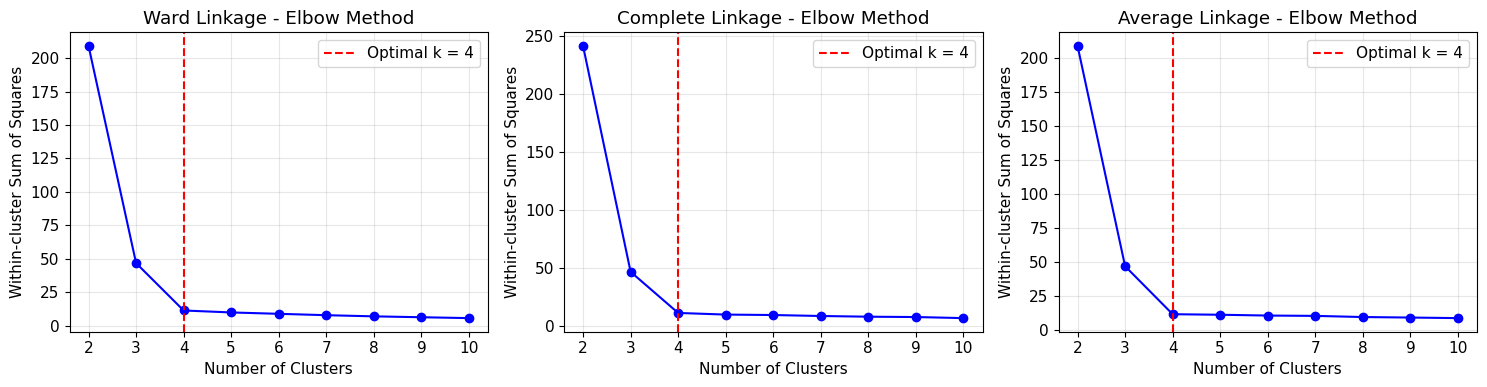


Fitting hierarchical clustering...
Hierarchical clustering completed:
- Linkage method: ward
- Number of clusters: 4
- Cluster sizes: [50 50 50 50]

Evaluating clustering quality...

Clustering Quality Metrics:
------------------------------
Silhouette Score         : 0.8017
Calinski Harabasz        : 2231.4268
Davies Bouldin           : 0.2708
Adjusted Rand Score      : 1.0000
Normalized Mutual Info   : 1.0000
Fowlkes Mallows          : 1.0000
Homogeneity              : 1.0000
Completeness             : 1.0000
V Measure                : 1.0000

Generating visualizations...


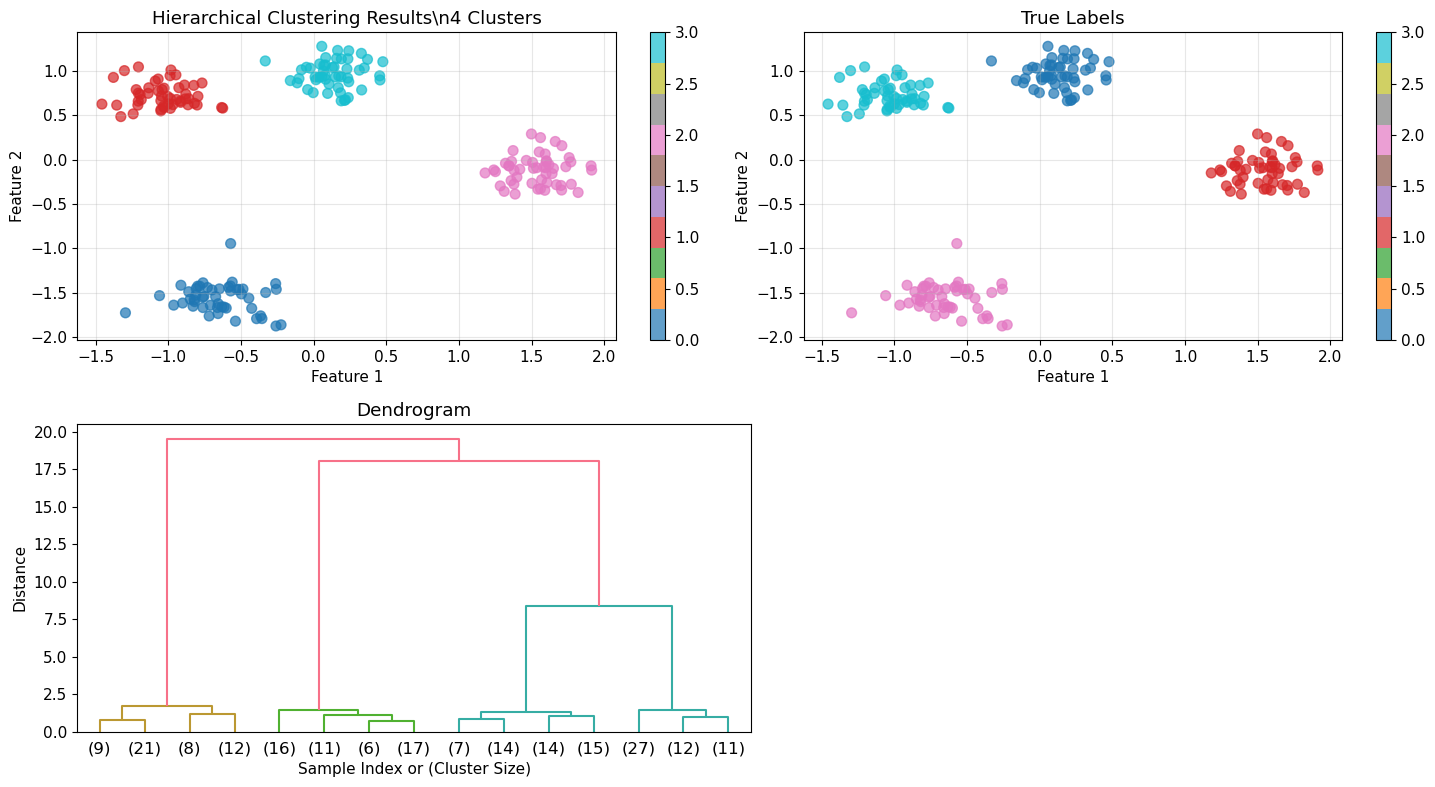


Comparing linkage methods...

CLUSTERING COMPARISON RESULTS

WARD LINKAGE:
--------------------
Silhouette Score         : 0.8017
Calinski Harabasz        : 2231.4268
Davies Bouldin           : 0.2708

COMPLETE LINKAGE:
--------------------
Silhouette Score         : 0.8017
Calinski Harabasz        : 2231.4268
Davies Bouldin           : 0.2708

AVERAGE LINKAGE:
--------------------
Silhouette Score         : 0.8017
Calinski Harabasz        : 2231.4268
Davies Bouldin           : 0.2708

SINGLE LINKAGE:
--------------------
Silhouette Score         : 0.8017
Calinski Harabasz        : 2231.4268
Davies Bouldin           : 0.2708

CLUSTERING COMPARISON RESULTS

WARD LINKAGE:
--------------------
Silhouette Score         : 0.8017
Calinski Harabasz        : 2231.4268
Davies Bouldin           : 0.2708

COMPLETE LINKAGE:
--------------------
Silhouette Score         : 0.8017
Calinski Harabasz        : 2231.4268
Davies Bouldin           : 0.2708

AVERAGE LINKAGE:
--------------------
Silhouette

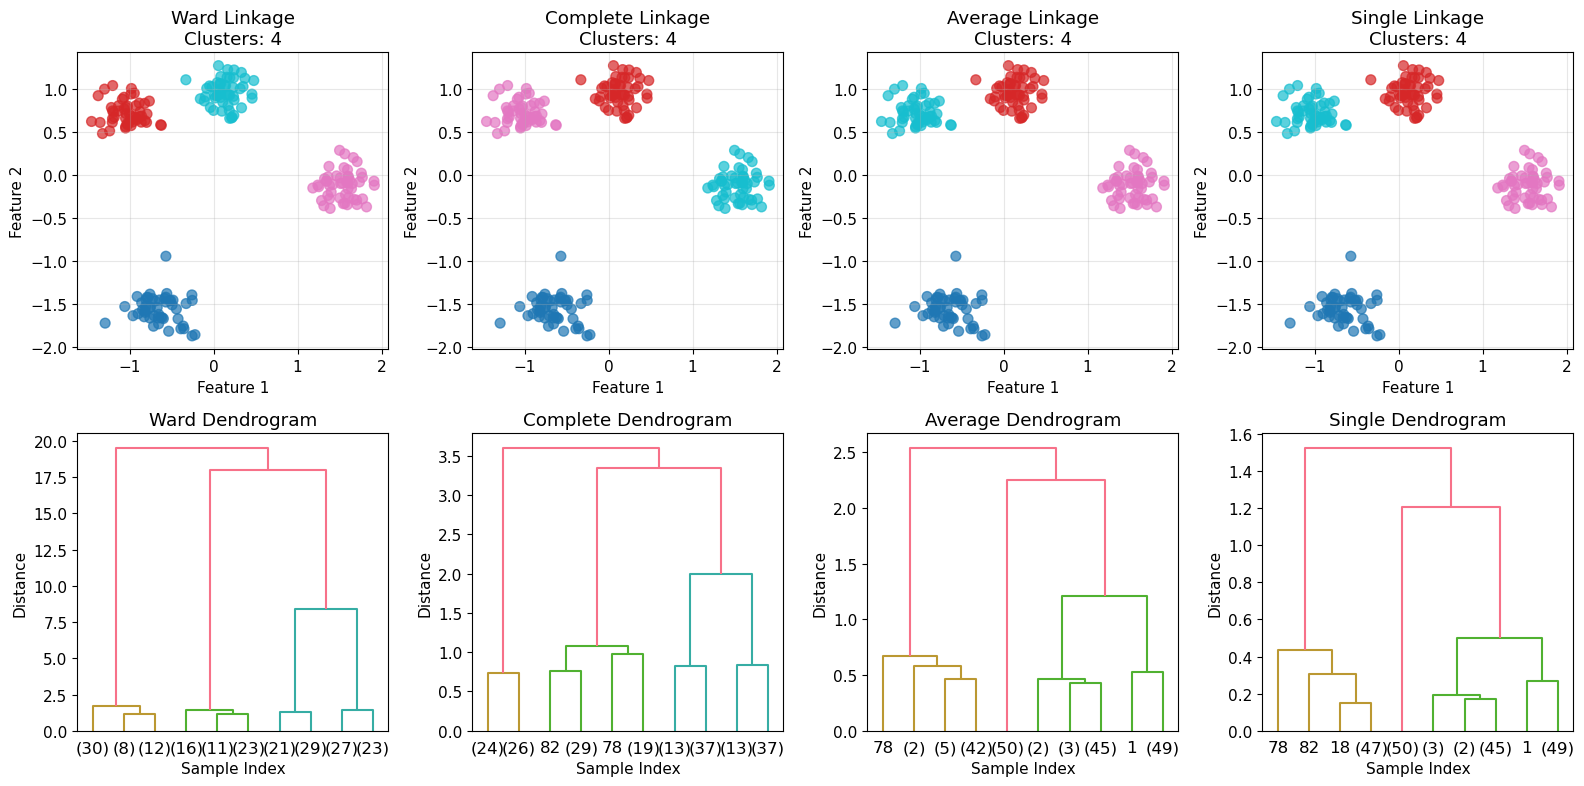



ANALYZING DATASET: CIRCLES
Data shape: (200, 2)
True number of classes: 2
Removed 0 duplicate rows
Data standardized

Finding optimal number of clusters...
Ward linkage optimal clusters: 4
Complete linkage optimal clusters: 4
Average linkage optimal clusters: 4


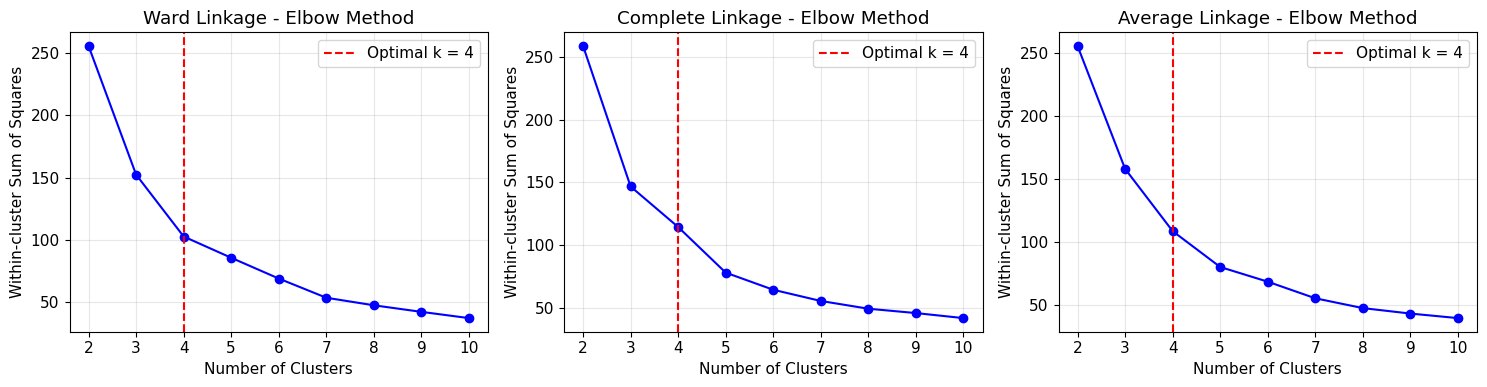


Fitting hierarchical clustering...
Hierarchical clustering completed:
- Linkage method: ward
- Number of clusters: 4
- Cluster sizes: [51 60 53 36]

Evaluating clustering quality...

Clustering Quality Metrics:
------------------------------
Silhouette Score         : 0.3875
Calinski Harabasz        : 188.8611
Davies Bouldin           : 0.7799
Adjusted Rand Score      : 0.0037
Normalized Mutual Info   : 0.0125
Fowlkes Mallows          : 0.3580
Homogeneity              : 0.0186
Completeness             : 0.0094
V Measure                : 0.0125

Generating visualizations...


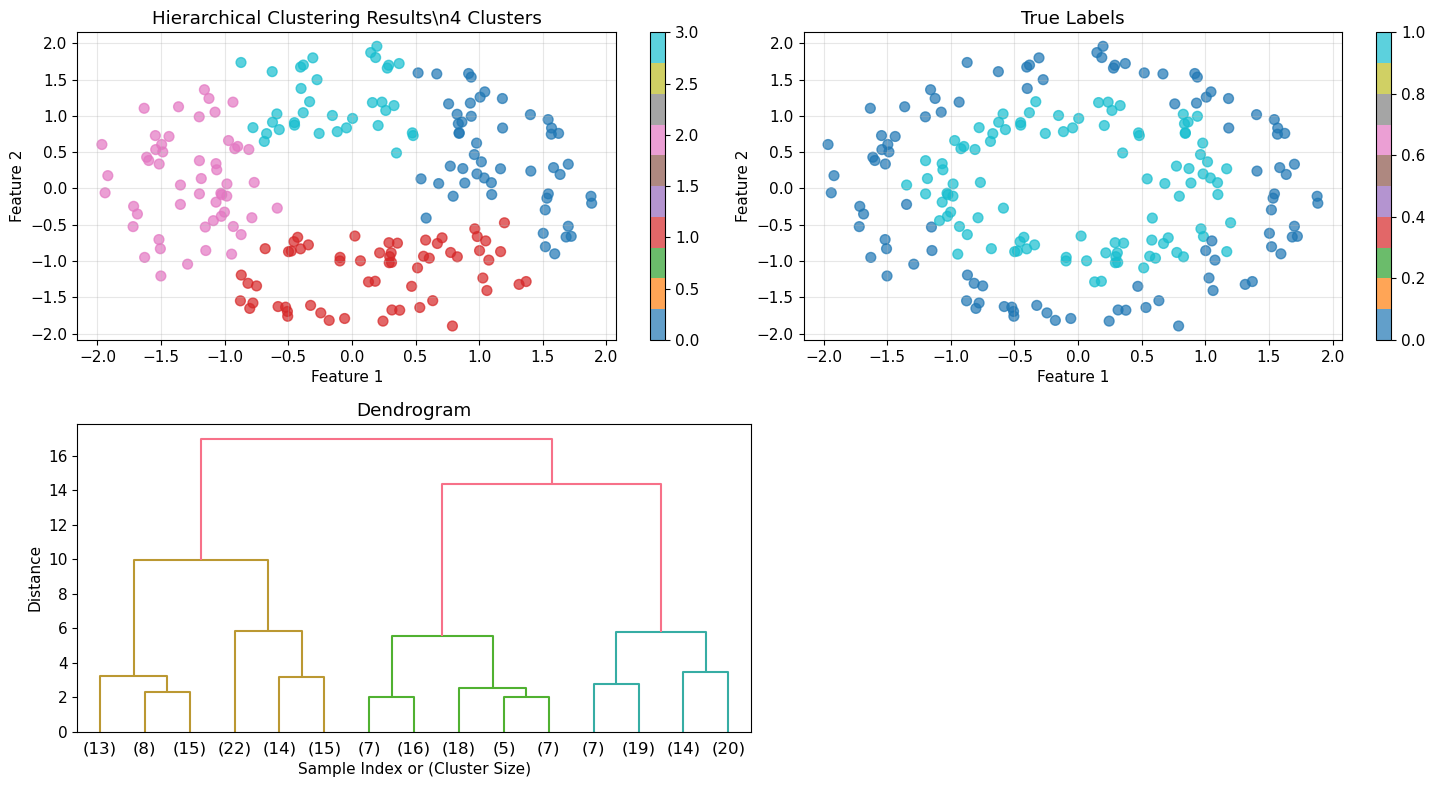


Comparing linkage methods...

CLUSTERING COMPARISON RESULTS

WARD LINKAGE:
--------------------
Silhouette Score         : 0.3511
Calinski Harabasz        : 112.0659
Davies Bouldin           : 1.1936

COMPLETE LINKAGE:
--------------------
Silhouette Score         : 0.3489
Calinski Harabasz        : 108.3605
Davies Bouldin           : 1.1378

AVERAGE LINKAGE:
--------------------
Silhouette Score         : 0.3520
Calinski Harabasz        : 111.8966
Davies Bouldin           : 1.1870

SINGLE LINKAGE:
--------------------
Silhouette Score         : 0.1239
Calinski Harabasz        : 2.1263
Davies Bouldin           : 0.6586

CLUSTERING COMPARISON RESULTS

WARD LINKAGE:
--------------------
Silhouette Score         : 0.3511
Calinski Harabasz        : 112.0659
Davies Bouldin           : 1.1936

COMPLETE LINKAGE:
--------------------
Silhouette Score         : 0.3489
Calinski Harabasz        : 108.3605
Davies Bouldin           : 1.1378

AVERAGE LINKAGE:
--------------------
Silhouette Score  

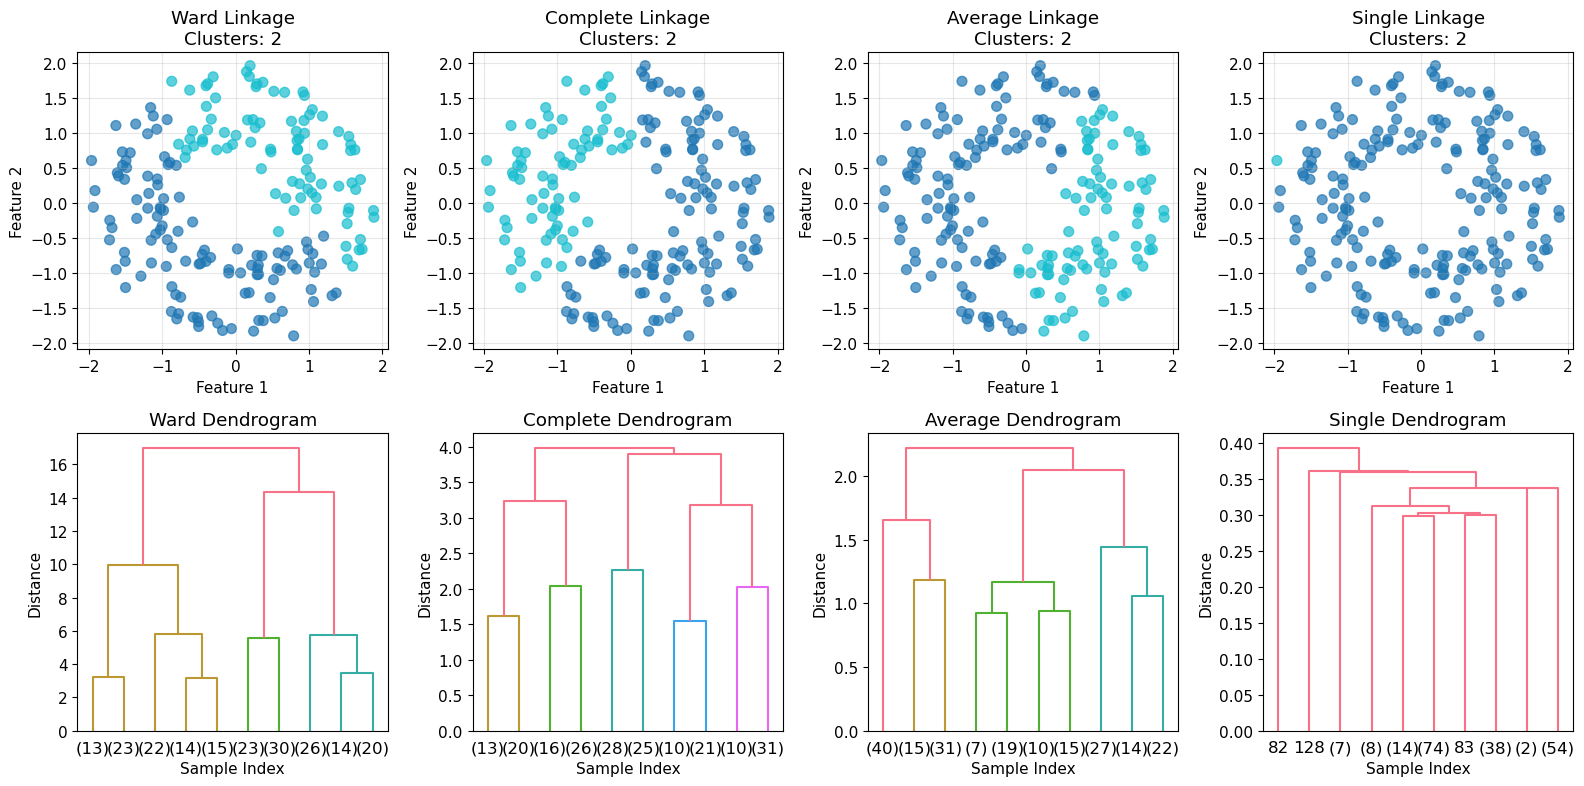



ANALYZING DATASET: MOONS
Data shape: (200, 2)
True number of classes: 2
Removed 0 duplicate rows
Data standardized

Finding optimal number of clusters...
Ward linkage optimal clusters: 5
Complete linkage optimal clusters: 6
Average linkage optimal clusters: 6


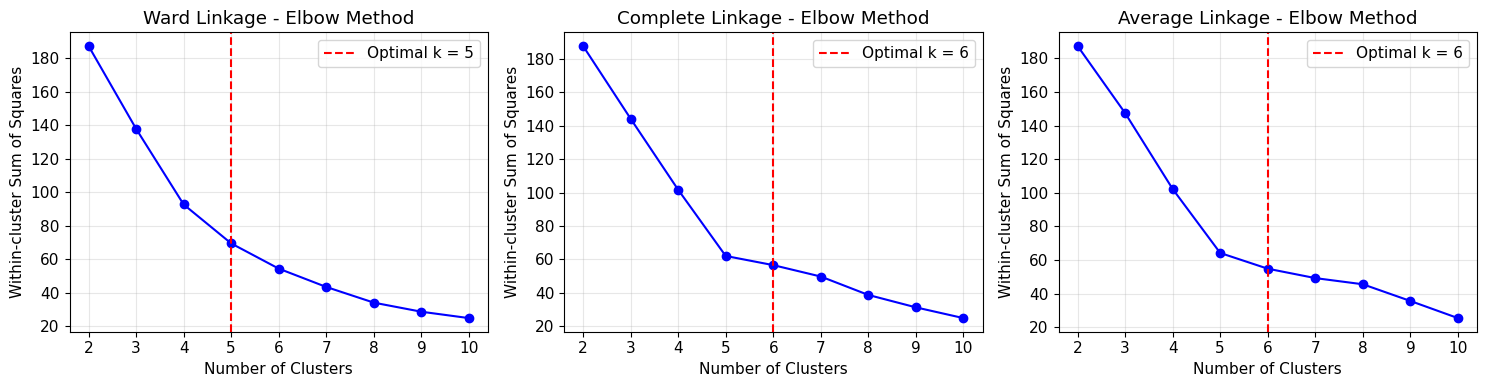


Fitting hierarchical clustering...
Hierarchical clustering completed:
- Linkage method: ward
- Number of clusters: 5
- Cluster sizes: [48 53 42 31 26]

Evaluating clustering quality...

Clustering Quality Metrics:
------------------------------
Silhouette Score         : 0.4130
Calinski Harabasz        : 231.9789
Davies Bouldin           : 0.7570
Adjusted Rand Score      : 0.3250
Normalized Mutual Info   : 0.4641
Fowlkes Mallows          : 0.5736
Homogeneity              : 0.7597
Completeness             : 0.3341
V Measure                : 0.4641

Generating visualizations...


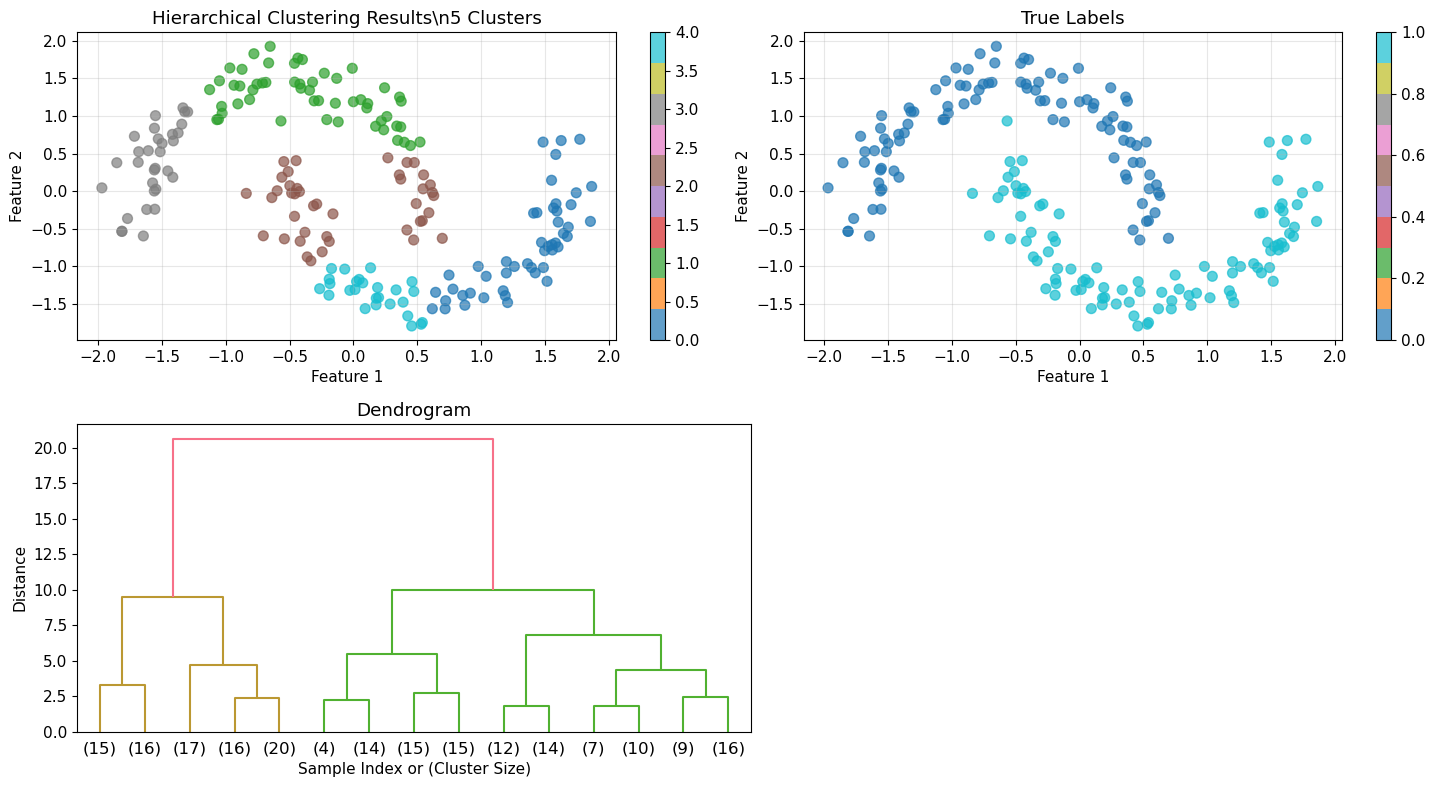


Comparing linkage methods...

CLUSTERING COMPARISON RESULTS

WARD LINKAGE:
--------------------
Silhouette Score         : 0.4505
Calinski Harabasz        : 224.6611
Davies Bouldin           : 0.8643

COMPLETE LINKAGE:
--------------------
Silhouette Score         : 0.4508
Calinski Harabasz        : 224.0592
Davies Bouldin           : 0.8534

AVERAGE LINKAGE:
--------------------
Silhouette Score         : 0.4505
Calinski Harabasz        : 224.6611
Davies Bouldin           : 0.8643

SINGLE LINKAGE:
--------------------
Silhouette Score         : 0.3732
Calinski Harabasz        : 165.9887
Davies Bouldin           : 1.0366

CLUSTERING COMPARISON RESULTS

WARD LINKAGE:
--------------------
Silhouette Score         : 0.4505
Calinski Harabasz        : 224.6611
Davies Bouldin           : 0.8643

COMPLETE LINKAGE:
--------------------
Silhouette Score         : 0.4508
Calinski Harabasz        : 224.0592
Davies Bouldin           : 0.8534

AVERAGE LINKAGE:
--------------------
Silhouette Score

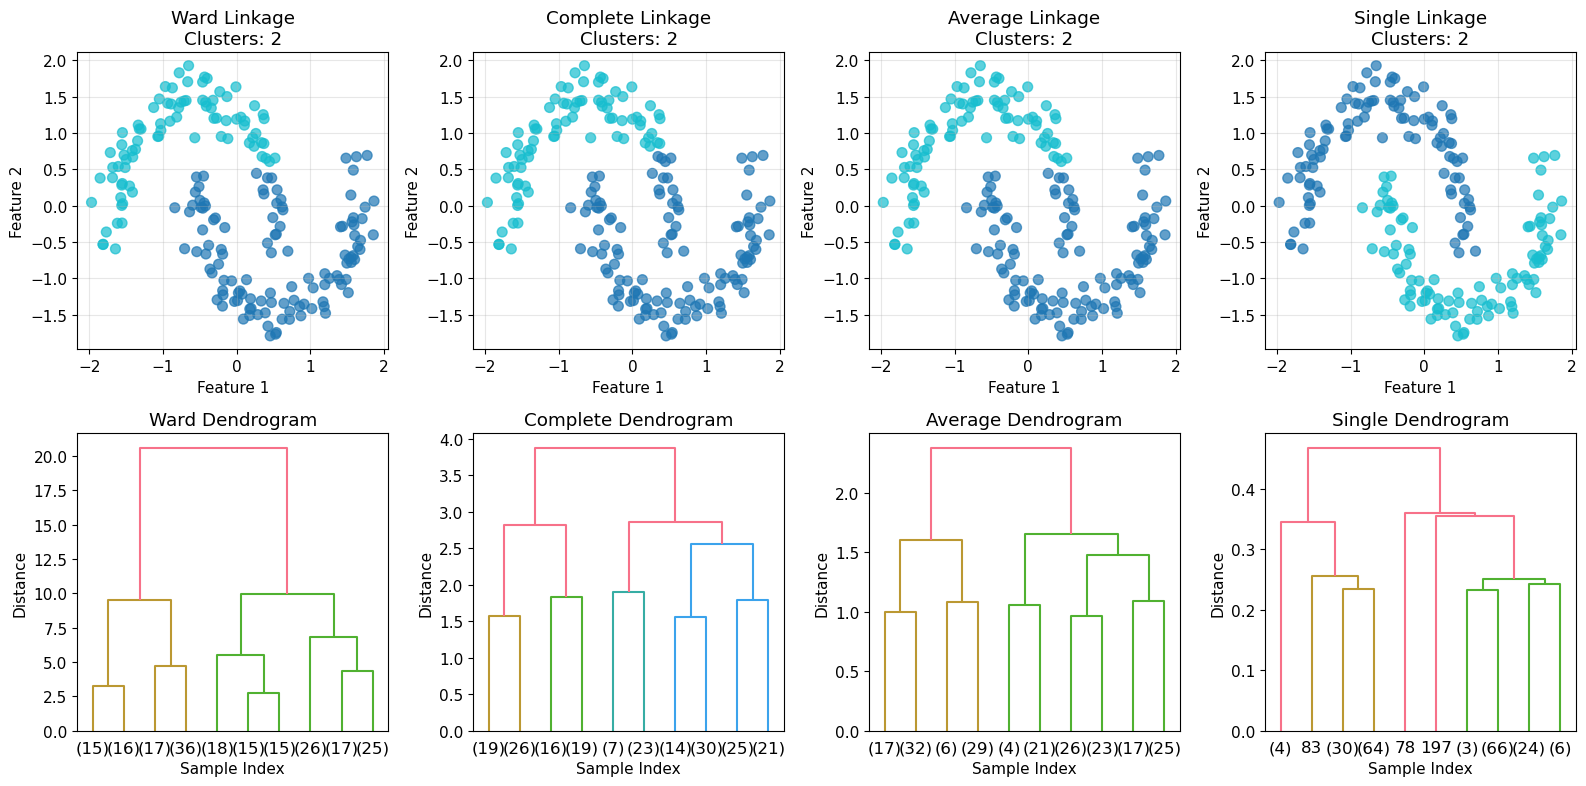



ANALYZING DATASET: ANISOTROPIC
Data shape: (200, 2)
True number of classes: 3
Removed 0 duplicate rows
Data standardized

Finding optimal number of clusters...
Ward linkage optimal clusters: 4
Complete linkage optimal clusters: 4
Average linkage optimal clusters: 4


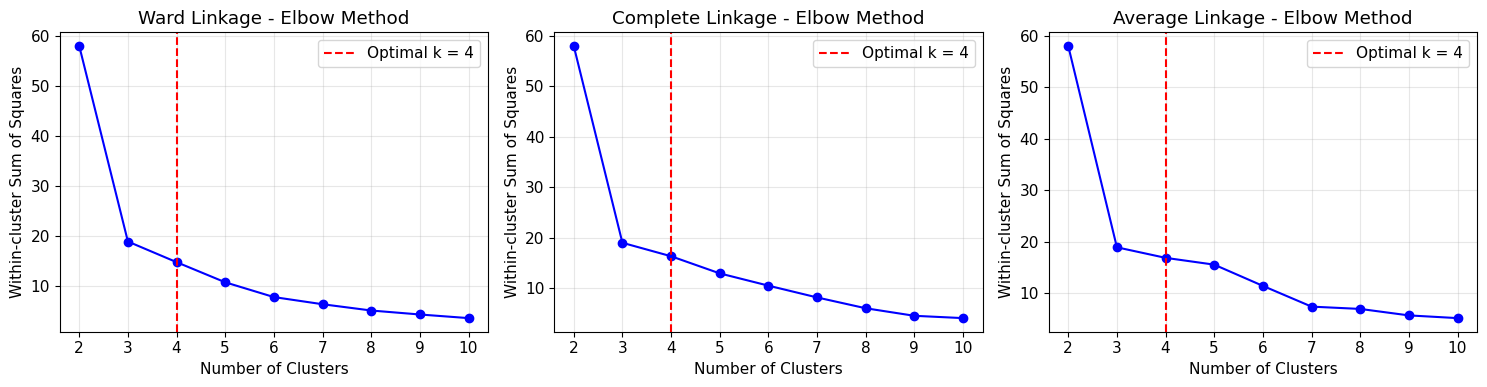


Fitting hierarchical clustering...
Hierarchical clustering completed:
- Linkage method: ward
- Number of clusters: 4
- Cluster sizes: [67 50 66 17]

Evaluating clustering quality...

Clustering Quality Metrics:
------------------------------
Silhouette Score         : 0.6836
Calinski Harabasz        : 1700.6460
Davies Bouldin           : 0.4438
Adjusted Rand Score      : 0.9001
Normalized Mutual Info   : 0.9205
Fowlkes Mallows          : 0.9330
Homogeneity              : 1.0000
Completeness             : 0.8527
V Measure                : 0.9205

Generating visualizations...


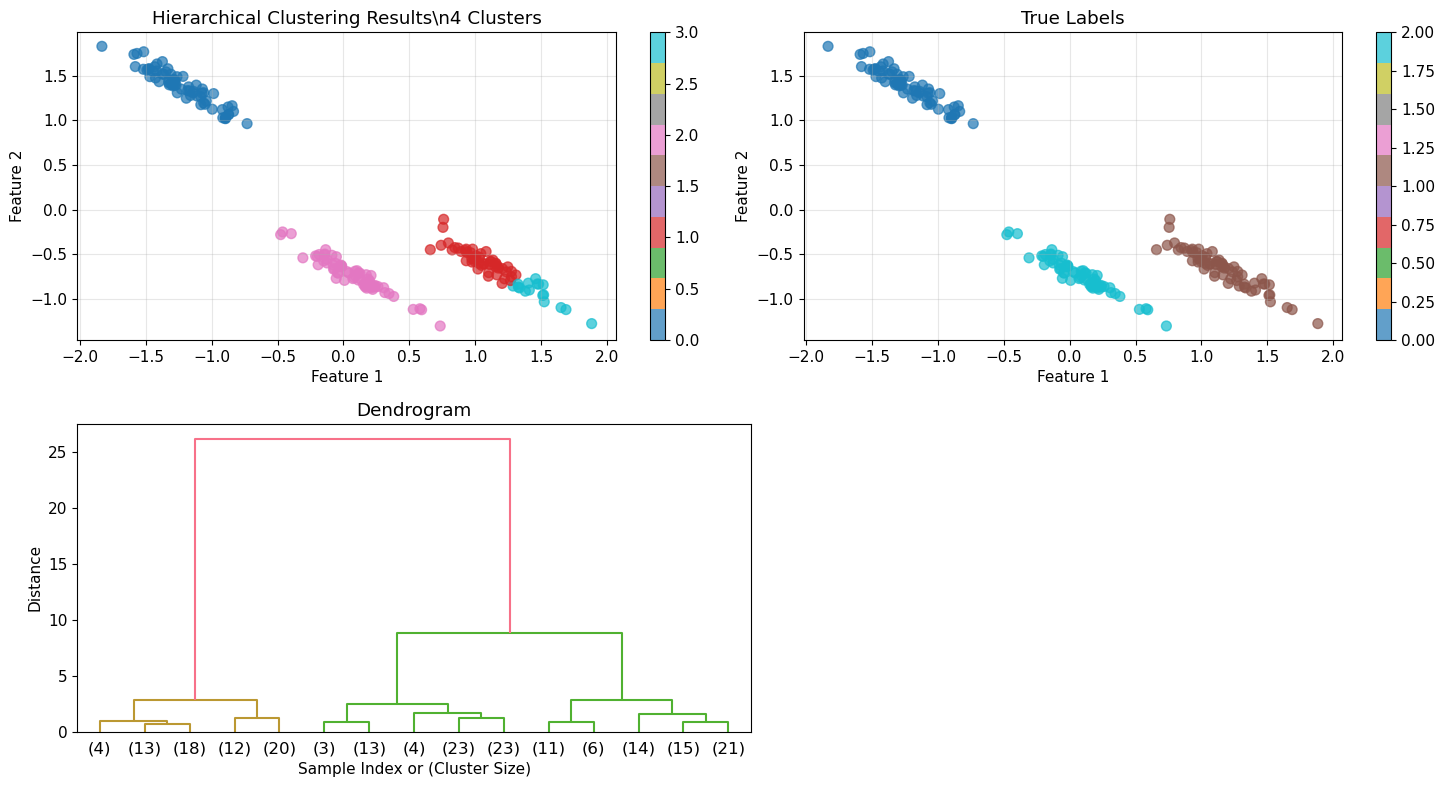


Comparing linkage methods...

CLUSTERING COMPARISON RESULTS

WARD LINKAGE:
--------------------
Silhouette Score         : 0.7364
Calinski Harabasz        : 1983.9079
Davies Bouldin           : 0.3713

COMPLETE LINKAGE:
--------------------
Silhouette Score         : 0.7317
Calinski Harabasz        : 1980.5511
Davies Bouldin           : 0.3693

AVERAGE LINKAGE:
--------------------
Silhouette Score         : 0.7364
Calinski Harabasz        : 1983.9079
Davies Bouldin           : 0.3713

SINGLE LINKAGE:
--------------------
Silhouette Score         : 0.7364
Calinski Harabasz        : 1983.9079
Davies Bouldin           : 0.3713

CLUSTERING COMPARISON RESULTS

WARD LINKAGE:
--------------------
Silhouette Score         : 0.7364
Calinski Harabasz        : 1983.9079
Davies Bouldin           : 0.3713

COMPLETE LINKAGE:
--------------------
Silhouette Score         : 0.7317
Calinski Harabasz        : 1980.5511
Davies Bouldin           : 0.3693

AVERAGE LINKAGE:
--------------------
Silhouette

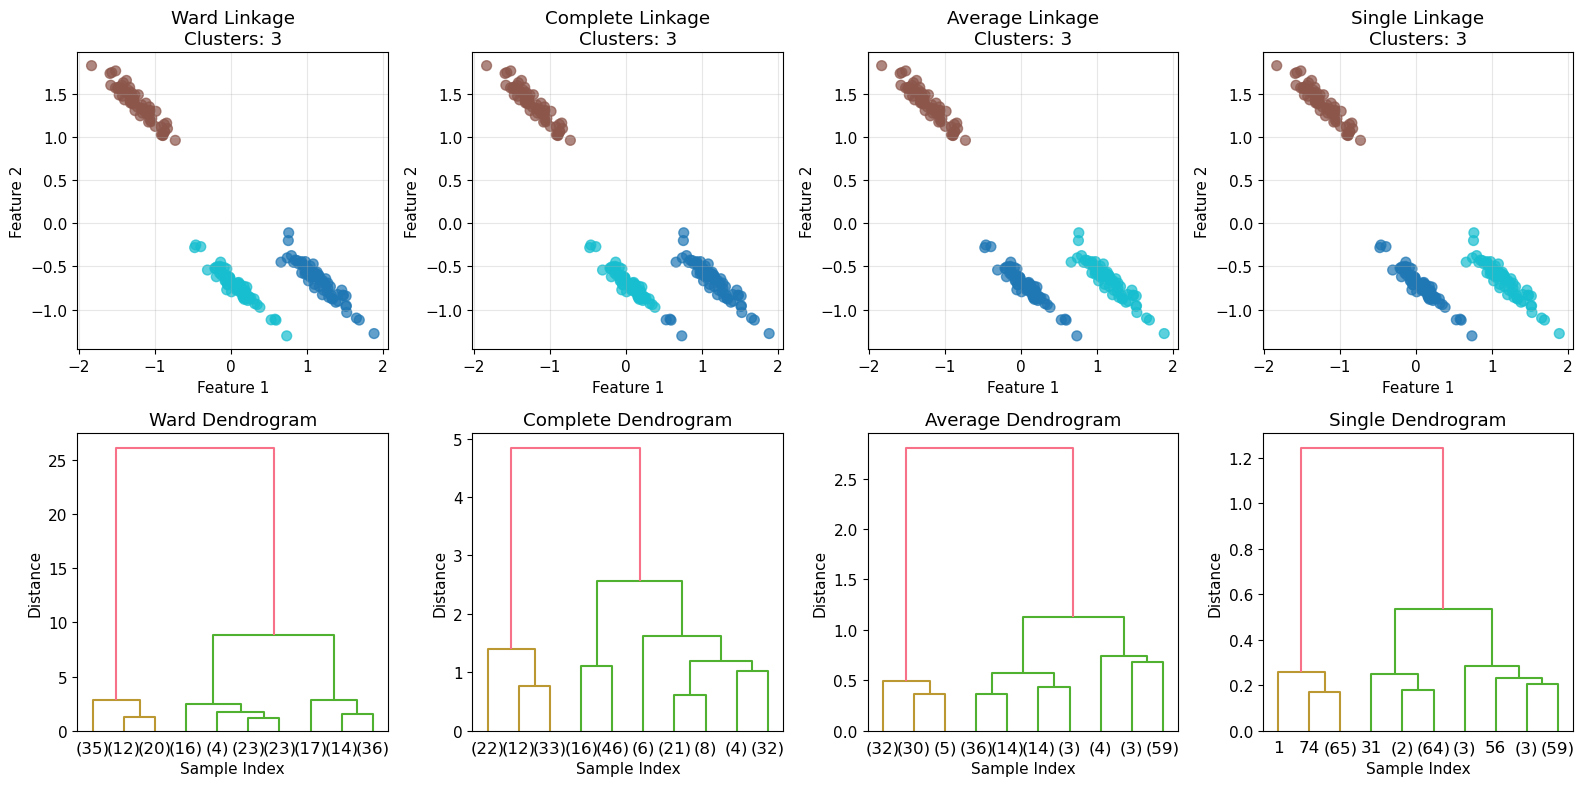

In [5]:
# Run synthetic dataset examples
if __name__ == '__main__':
    # Option 1: Run the demonstration on synthetic datasets
    print("Running synthetic dataset examples...\n")
    demonstrate_hierarchical_clustering()
    
    # Uncomment to run real-world datasets examples
    # print("\nRunning real-world dataset examples...\n")
    # real_world_results = apply_hierarchical_clustering_to_real_datasets()
    
    # Uncomment to run high-dimensional example with faces dataset
    # This can be computationally intensive
    # print("\nRunning hierarchical clustering with dimensionality reduction...\n")
    # faces_results = hierarchical_clustering_with_dimensionality_reduction()